<a href="https://colab.research.google.com/github/itaborai83/ecd221-ML-trabalho/blob/main/ML_7_Projeto_completo_de_Classifica%C3%A7%C3%A3o_Bin%C3%A1ria_Telco_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Especialização em Ciência de Dados - PUC-Rio
# Machine Learning - Prof. Tatiana Escovedo
# Projeto completo de Classificação Binária


## 1. Definição do Problema

Este trabalho foi realizado usando o dataset sobre rotatividade de clientes encontrado no link abaixo.

https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Trata-se de um dataset de classificação  binária com o objetivo de identificar se um determinado cliente irá encerrar ou não seu plano de internet/telefonia com uma operadora.

Cada linha representa um cliente e seus atributos, incluindo informações sobre os serviços contratados, informações sobre a conta do cliente e informações demográficas sobre os clientes.




Vamos instalar as bibliotecsa **phik** para cálculo do coeficiente de correlação Phi K, capaz de lidar com variáveis numéricas e categóricas.

Da biblioteca  **mlxtend** vamos utilizar o classificador **EnsembleVoteClassifier**, pois o mesmo suporta trabalhar com classificadores já treinados (a versão do scikit learn disponibilizado no Google Colab não permite isso, sempre treinando os classificadores).

Por fim, a biblioteca **six** está sendo instalada devido a um bug no código do classificador **EnsembleVoteClassifier** que carrega essa dependência de maneira incorreta e indireta. Trata-se de um bug no código da mesma.  

In [1]:
# função de correlação que funciona com v ariáveis categóricas e numéricas
! pip install phik mlxtend

# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
! pip install six 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports
import sys
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # transformador de colunas, usado para tratamento das variáveis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# a versão do Stacking classifier disponível no Colab não aceita classificadores pré-treinados
# from sklearn.ensemble import VotingClassifier

# correção de bug na biblioteca que importa uma dependência de maneira indireta
# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
import six
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import EnsembleVoteClassifier

import phik
from phik.report import plot_correlation_matrix
from phik import report

# redução de dimensionalidade
from sklearn.decomposition import PCA

# para baixar os modelos já treinados
import urllib.request

from pprint import pprint, pformat

import pickle # para persistência de modelos

In [3]:
# setup ambiente

# supressão de warnings
import warnings
warnings.filterwarnings("ignore")

# configura pandas para exibição de apenas duas casas decimais nas variaveis
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

# configura cores do Seaborn
sns.set()

In [4]:
# constantes

DATA_URL                    = f"https://raw.githubusercontent.com/itaborai83/ecd221-ML-trabalho/main/telco-churn.csv"
FIELD_SEPARATOR             = ","
IMPORT_COLUMN_NAMES         = [
    "customer_id"
,   "gender"
,   "senior_citizen"
,   "partner"
,   "dependents"
,   "tenure"
,   "phone_service"
,   "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "paperless_billing"
,   "payment_method"
,   "monthly_charges"
,   "total_charges"
,   "churn"
]
COLUMN_NAMES = [
    "gender"
,   "senior_citizen"
,   "partner"
,   "dependents"
,   "phone_service"
,   "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "paperless_billing"
,   "payment_method"
,   "tenure"
,   "monthly_charges"
,   "total_charges"
,   "churn"
]
TARGET_VARIABLE = "churn"
BOOLEAN_FEATURES = [
    "senior_citizen"
,   "partner"
,   "dependents"
,   "phone_service"
,   "paperless_billing"
]
CATEGORICAL_FEATURES = [
    "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "payment_method"
]
NUMERICAL_FEATURES                  = ["tenure", "monthly_charges", "total_charges"]
NUMERICAL_FEATURES_AFTER_FEAT_ENG   = ["tenure", "monthly_charges", "total_charges", "client_factor", "internet_factor", "financial_factor", "multi_factor"]
BOOLEAN_MAP                         = {"No": 0, "Yes": 1}
TEST_PCT_SIZE                       = 0.3 # 30% do conjunto de dados
RANDOM_STATE                        = 42
SCORING_METRIC                      = "recall"
K_FOLDS                             = 6
RETURN_TRAIN_SCORE                  = False
OUTPUT_TRAINING_FILE_TMPLT          = "RandomizedSearchCV_{algo}.xlsx"
QUICK_RUN                           = False
TRAIN_ALL                           = True
DOWNLOAD_ALL                        = False
DOWNLOAD_MODELS_URL                 = "https://github.com/itaborai83/ecd221-ML-trabalho/raw/main/"
MODEL_SETTINGS                      = {
     "logreg"           : { "model_file": "logreg.pkl", "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "Regressão Logística" }
,    "knn"              : { "model_file": "knn.pkl",    "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "K-Nearest Neighbors" }
,    "nb"               : { "model_file": "nb.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "Gaussian Naive Bayes" }
,    "dt"               : { "model_file": "dt.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "Árvore de Decisão" }
,    "svm"              : { "model_file": "svm.pkl",    "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "SVM" }
,    "ada"              : { "model_file": "ada.pkl",    "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "AdaBoost" }
,    "gb"               : { "model_file": "gb.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "GradientBoosting" }
,    "rf"               : { "model_file": "rf.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "RandomForest" }
,    "vt"               : { "model_file": "vt.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "Voting Ensemble" }
}

RESULT_COLUMNS = ["algoritmo", "acurácia", "precisão", "recall", "F1", "ROC AUC"]
RESULTS = { }



## 2. Carga de Dados

O pacote Pandas será utilizado para carregar o conjunto de dados.

A variável target, **churn**, será convertida de **No** ou **Yes** para 0 ou 1.

O identificador do cliente, **customer_id** será eliminado, pois não ajuda no processo de classificação dos clientes.

In [5]:
# Carrega arquivo csv usando Pandas usando uma URL
churn_df = pd.read_csv(
    DATA_URL
,   names     = IMPORT_COLUMN_NAMES
,   skiprows  = 1
,   delimiter = ','
)

# transforma a variável target em uma variável numérica
churn_df["churn"] = churn_df["churn"].map(BOOLEAN_MAP)

# excluindo a variável customer_id
del churn_df["customer_id"]

for algo in MODEL_SETTINGS:
  model_setting = MODEL_SETTINGS[algo]
  download      = model_setting["download"]
  model_file    = model_setting["model_file"]
  if download:
    url = DOWNLOAD_MODELS_URL + model_file
    urllib.request.urlretrieve(url, model_file)

O dataset possui 7043 linhas, contendo cada uma 29 atributos.

In [6]:
churn_df.shape

(7043, 20)

O dataset é majoritariamente categórico, possuindo apenas as variáveis numéricas **tenure**, **monthly_charges** e **total_charges**.




In [7]:
churn_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## 3. Análise de Dados

### 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [8]:
# Mostra as informações do dataset
print(churn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

Como mencionado, o dataset possui predominantesmente dados categóricos, representados acima como objetos com tipo de dados **object**

In [9]:
# Mostra as 10 primeiras linhas do dataset
churn_df.head(10)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,0
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


A variável **monthly_charges** aparenta ser numérica. Ao tentar convertê-a para o tipo **float**, o seguinte erro ocorreu "*ValueError: could not convert string to float*".


In [10]:
# a conversão do tipo da coluna abaixo falha com o erro "ValueError: could not convert string to float"
# churn_df["total_charges"] = churn_df["total_charges"].astype(float)

# tenta identificar valores problemáticos
def convertible_to_float(value):
  try:
    f = float(value)
    return True
  except:
    return False
is_float = churn_df["total_charges"].map(convertible_to_float)
churn_df["total_charges_is_float"] = is_float
display(churn_df[ churn_df["total_charges_is_float"] == False ][ "total_charges" ].map(repr))

display(churn_df[ churn_df["total_charges_is_float"] == False ][ ["total_charges", "tenure", "monthly_charges"] ])


488     ' '
753     ' '
936     ' '
1082    ' '
1340    ' '
3331    ' '
3826    ' '
4380    ' '
5218    ' '
6670    ' '
6754    ' '
Name: total_charges, dtype: object

,total_charges,tenure,monthly_charges
488,,0,52.55
753,,0,20.25
936,,0,80.85
1082,,0,25.75
1340,,0,56.05
3331,,0,19.85
3826,,0,25.35
4380,,0,20.00
5218,,0,19.70
6670,,0,73.35


O dataframe possui 11 registros com valor ' ' na coluna total_charges.

Em todos o casos, são clientes com 0 meses de prestação de serviços (variável **tenure**).

Os valores de **total_charges** serã convertidos para zero.


In [11]:
def convert_total_charges(value):
    return 0.0 if value == ' ' else value

churn_df["total_charges"] = churn_df["total_charges"].map(convert_total_charges).astype(float)
del churn_df["total_charges_is_float"]

Diferente das outras variáveis categóricas, a variável **senior_citizem** está utilizando 0's e 1's para representar verdadeiro e falso. Iremos converter estes dados momentamenteamente por questões de consistência

In [12]:
churn_df["senior_citizen"] = churn_df["senior_citizen"].map({1: "Yes", 0: "No"})

O dataset não aparenta possuir mais valores faltantes e os tipos de dados para variáveis categóricas e numéricas parecem estar corretos agora.

In [13]:
# Verifica o tipo de dataset de cada atributo
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   object 
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

In [14]:
# Faz um resumo estatístico das variáveis numéricas do dataset (média, desvio padrão, mínimo, máximo e os quartis)
churn_df.describe()

,tenure,monthly_charges,total_charges,churn
count,7043.00,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.73,0.27
std,24.56,30.09,2266.79,0.44
min,0.00,18.25,0.00,0.00
25%,9.00,35.50,398.55,0.00
50%,29.00,70.35,1394.55,0.00
75%,55.00,89.85,3786.60,1.00
max,72.00,118.75,8684.80,1.00


A variável **total_charges** é numericamente muito próxima das variáveis **tenure** e **monthly_charges**.

Apesar disso, a variável será mantida para não reduzir ainda mais a o número de variáveis numéricas presentes no conjunto de dados.

In [15]:
churn_df["tenure*monthly"] = churn_df["tenure"] * churn_df["monthly_charges"]
churn_df["churn"] = churn_df.pop("churn")
display(churn_df.describe())
del churn_df["tenure*monthly"]

,tenure,monthly_charges,total_charges,tenure*monthly,churn
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.73,2279.58,0.27
std,24.56,30.09,2266.79,2264.73,0.44
min,0.00,18.25,0.00,0.00,0.00
25%,9.00,35.50,398.55,394.00,0.00
50%,29.00,70.35,1394.55,1393.60,0.00
75%,55.00,89.85,3786.60,3786.10,1.00
max,72.00,118.75,8684.80,8550.00,1.00


Analisando os valores acimas, não conseguimos identificar valores faltantes inválidos ou outliers.

Analisando a variável target, **churn**, podemos constatar que o conjunto de dados apresenta desbalanceamento, havendo uma maior ocorrência da classe 0 (permaneceu cliente) do que a classe 1 (não permaneceu cliente).

Devido a isso, não iremos usar a métrica **acurácia** para guiar o processo de tunning dos hiperparâmetros, mas sim a métrica **área sob a curva ROC** para indicar o quão bem os diferentes modelos conseguem separar as classes da variável target. 

In [16]:
# distribuição das classes
pd.crosstab(churn_df[TARGET_VARIABLE], churn_df[TARGET_VARIABLE], normalize=True)

churn,0,1
churn,,
0,0.73,0.00
1,0.00,0.27


Não está claro se o balanceamento de classes e a distribuição das variáveis do dataset correspondem à dados observados na vida real ou se algum tipo de curadoria ou rebalanceamento foi realizado (dado que a rotatividade de clientes na ordem de 27% parece ser um percentual muito elevado).

Dado o elevado número de variáveis categóricas, iremos realizar um estudo das tabulações cruzadas das variáveis categóricas com a variável target, **churn** para tentar identificar padrões possivelmetne úteis presentes no conjunto de dados.

A variável **gender** está balanceada no dataset e também balanceado quando comparada à variável target. Não está claro se essa variável é realmente útil.

In [17]:
pd.crosstab(churn_df["gender"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
gender,,,
Female,0.36,0.13,0.50
Male,0.37,0.13,0.50
All,0.73,0.27,1.00


A variável categórica **senior_citizen** parece influenciar a rotatividade de clientes.

Se por um lado 84% dos clientes não estão na terceira idade, aproximadamente 75% (20%/27%) dos ex-clientes pertencem à esta categoria.

Por sua vez, os clientes pertencentes à terceira idade correspondem a apenas 16% dos clientes, mas desses 16%, 43% deixaram de ser clientes.

Em outras palavras. Em termos absolutos, um ex-cliente tem maior probabilidade de não pertencer a terceira idade. Em contra-partida, dado que um cliente pertence à terceira idade, ele tem maior probabilidade de se tornar um ex-cliente.




In [18]:
pd.crosstab(churn_df["senior_citizen"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
senior_citizen,,,
No,0.64,0.20,0.84
Yes,0.09,0.07,0.16
All,0.73,0.27,1.00


A variável **partner**, que indica se um cliente possui ou não algum tipo de parceiro/cônjuge parece estar bem distribuída no conjunto de dados com aproximadamente metade dos clientes tendo algum parceiro e a outra metade não.

Entretanto, podemos que observar que a retenção dos clientes tende a ser pior entre os clientes que não possuem algum tipo de parceiro, pois aproximadamente 2/3 dos ex-clientes enquadram-se nessa situação

In [19]:
pd.crosstab(churn_df["partner"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
partner,,,
No,0.35,0.17,0.52
Yes,0.39,0.09,0.48
All,0.73,0.27,1.00


A variável **dependents**, que indica se um cliente possui ou não algum tipo de dependente parece ser um forte indicador sobre a rotatividade dos clientes pois mais de 81% (22%/27%) dos ex-clientes não possuem dependentes.

In [20]:
pd.crosstab(churn_df["dependents"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
dependents,,,
No,0.48,0.22,0.70
Yes,0.25,0.05,0.30
All,0.73,0.27,1.00


A variável **tenure**, que representa o número de meses em que um cliente possui algum tipo de relacionamento comercial com a empresa, parece indicar que a empresa oferece planos/contratos de duração máxima de 72 meses (ou que clientes com mais do que 72 meses são agrupados nessa categoria)

Analisando os clientes que permaneceram com a empresa, podemos obseravar uma distribuição em forma de U, onde um número sigificativo de clientes possuem poucos meses de relacionamento e um número ainda maior parece estar se aproximando do teto de 72 meses.

Por sua vez, a análise dos futuros ex-clientes indicam que a maioria parece cancelar seus serviços nos primeiros meses de relacionamento com a empresa e, passado o tempo, fidelizam-se.

Estas distribuições parecem indicar a necessidade de que medidas de fidelização sejam tomadas nos críticos primeiros meses.

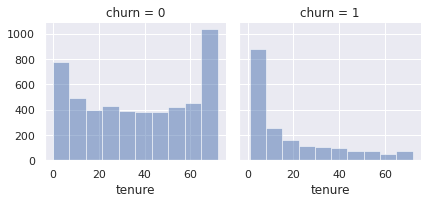

In [21]:
g = sns.FacetGrid(churn_df, col="churn", size=3)
g.map_dataframe(plt.hist, x="tenure", alpha=0.5)
g.add_legend();

A variável **phone_service** está desbalanceada e o fato de um usuário não possuir nenhum tipo de serviço telefônico contratado parece não ser expressivo em termos absolutos ou relativos

In [22]:
pd.crosstab(churn_df["phone_service"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
phone_service,,,
No,0.07,0.02,0.10
Yes,0.66,0.24,0.90
All,0.73,0.27,1.00


A variável **multiple_lines** parece não informações significativas para determinar a rotatividade dos clientes

In [23]:
pd.crosstab(churn_df["multiple_lines"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
multiple_lines,,,
No,0.36,0.12,0.48
No phone service,0.07,0.02,0.10
Yes,0.30,0.12,0.42
All,0.73,0.27,1.00


A variável **internet_service** usada para identificar qual o tipo de fornecimento de internet o usuário possui (ou não) indica que quase 2/3 entre todos os ex-clientes parecem ter contratado internet por fibra ótica.

Isso parece indicar a existência de problemas na qualidade do fornecimento do serviço ou na precificação do mesmo.

In [24]:
pd.crosstab(churn_df["internet_service"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
internet_service,,,
DSL,0.28,0.07,0.34
Fiber optic,0.26,0.18,0.44
No,0.20,0.02,0.22
All,0.73,0.27,1.00


O serviço de fibra ótica, conforme esperado, parece contribuir com o aumento dos custos mensais dos clientes e consequentemente afetando negativamente na retenção dos clientes que contrataram esse serviço.

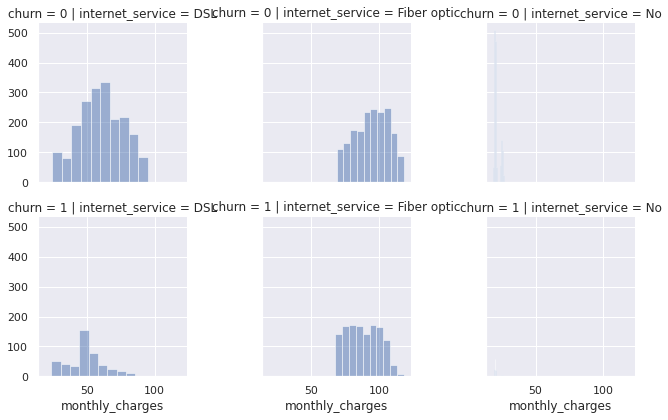

In [25]:
g = sns.FacetGrid(churn_df, col="internet_service", row="churn", size=3)
g.map_dataframe(plt.hist, x="monthly_charges", alpha=0.5)
g.add_legend();

Análise da variável **total_charges** nos revela, como já esperado, que os clientes novos que contrataram a internet mais cara(fibra ótica), tem a maior probabilidade de cancelarem os seus serviços.

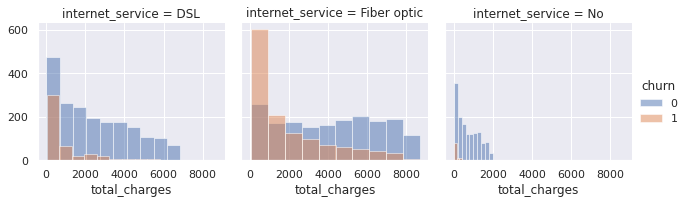

In [26]:
g = sns.FacetGrid(churn_df, col="internet_service", hue="churn", size=3)
g.map_dataframe(plt.hist, x="total_charges", alpha=0.5)
g.add_legend();

As variáveis **online_security**, **online_backup**, **device_protection** e **tech_support** comportam-se de maneira parecida. Em todos os casos, a não contratação dos serviços parecem aumentar a probabilidade do cliente desfazer seu relacionamento com a empresa.

Em outras palavras, a contratação desses serviços parece ser indicativo de que um cliente está fidelizado.


In [27]:
pd.crosstab(churn_df["online_security"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
online_security,,,
No,0.29,0.21,0.50
No internet service,0.20,0.02,0.22
Yes,0.24,0.04,0.29
All,0.73,0.27,1.00


In [28]:
pd.crosstab(churn_df["online_backup"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
online_backup,,,
No,0.26,0.18,0.44
No internet service,0.20,0.02,0.22
Yes,0.27,0.07,0.34
All,0.73,0.27,1.00


In [29]:
pd.crosstab(churn_df["device_protection"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
device_protection,,,
No,0.27,0.17,0.44
No internet service,0.20,0.02,0.22
Yes,0.27,0.08,0.34
All,0.73,0.27,1.00


In [30]:
pd.crosstab(churn_df["tech_support"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
tech_support,,,
No,0.29,0.21,0.49
No internet service,0.20,0.02,0.22
Yes,0.25,0.04,0.29
All,0.73,0.27,1.00


As variáveis **streaming_movies** e **streaming_tv** parecem não influenciar de forma significativa a rotatividade dos clientes, possivelmente por se tratarem de serviços de uso muito prevalente.

In [31]:
pd.crosstab(churn_df["streaming_tv"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
streaming_tv,,,
No,0.27,0.13,0.40
No internet service,0.20,0.02,0.22
Yes,0.27,0.12,0.38
All,0.73,0.27,1.00


In [32]:
pd.crosstab(churn_df["streaming_movies"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
streaming_movies,,,
No,0.26,0.13,0.40
No internet service,0.20,0.02,0.22
Yes,0.27,0.12,0.39
All,0.73,0.27,1.00


Aproximadamente 85% da rotatividade dos clientes ocorrem entre aqueles que possuem contratos mensais, aparentando-ser um dos principais fatores que contribuem com a rotatividade dos clientes.

Os clientes tendem a permanecer fidelizados pela duração do contrato vigente que assinaram com a empresa de telefonia/telecomunicações.

In [33]:
pd.crosstab(churn_df["contract"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
contract,,,
Month-to-month,0.32,0.23,0.55
One year,0.19,0.02,0.21
Two year,0.23,0.01,0.24
All,0.73,0.27,1.00


Clientes que possuem cobrança digital tendem a ter uma rotatividade mais alta do que clientes cobrados de maneira impressa.

In [34]:
pd.crosstab(churn_df["paperless_billing"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
paperless_billing,,,
No,0.34,0.07,0.41
Yes,0.39,0.20,0.59
All,0.73,0.27,1.00


os métodos de pagamento presentes no dataset estão todos balanceados quando compara-se os cliente que permaneceram contratando os serviços da empresa.

Entre os ex-clientes, a probabilidade de que o método de pagamento empregado tenha sido cheques eletrônicos (depósitos automáticos) é consideravelmente maior, conforme dados acima.

In [35]:
pd.crosstab(churn_df["payment_method"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn,0,1,All
payment_method,,,
Bank transfer (automatic),0.18,0.04,0.22
Credit card (automatic),0.18,0.03,0.22
Electronic check,0.18,0.15,0.34
Mailed check,0.19,0.04,0.23
All,0.73,0.27,1.00


Conforme analisada realizada anteriormente, a variável **monthly_charges** parece ter uma significativa correlação positiva com a rotatividade dos clientes. 

Foi observado que o serviço contratado de internet de fibra ótica parece ser, dentre os serviços existentes, aquele que mais contribui com o aumento do valor mensal cobrado e que, consequentemente, mais influencia na rotatividade.

Ademais, os dados dos ex-clientes parecem indicar a existência de uma distribuição tri-modal composta primeiramente pelos clientes que utilizam-se apenas dos serviços de telefonia, subsequentemente, os clientes que utilizam-se da internet via DSL e, por último, os clientes que se utilizam da internet via fibra ótica.

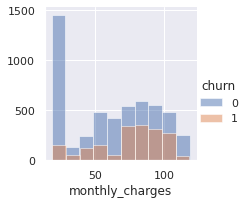

In [36]:
g = sns.FacetGrid(churn_df, hue="churn", size=3)
g.map_dataframe(plt.hist, x="monthly_charges", alpha=0.5)
g.add_legend();

Com base nas análises acima, as seguintes ações serão tomadas

*   Variável **gender** será eliminada;
*   As variáveis categóricas serão posteriormente tratadas.



In [37]:
del churn_df["gender"]
# reposicionando a variável target no final
churn_df["churn"] = churn_df.pop("churn")


### 3.2. Visualizações Unimodais Dados Numéricos

Vamos criar agora um histograma para cada atributo do dataset.

Os histogramas não indicam a presença de outliers no conjunto de dados.

Nenhum das variáveis aparenta estar distribuída normalmente.

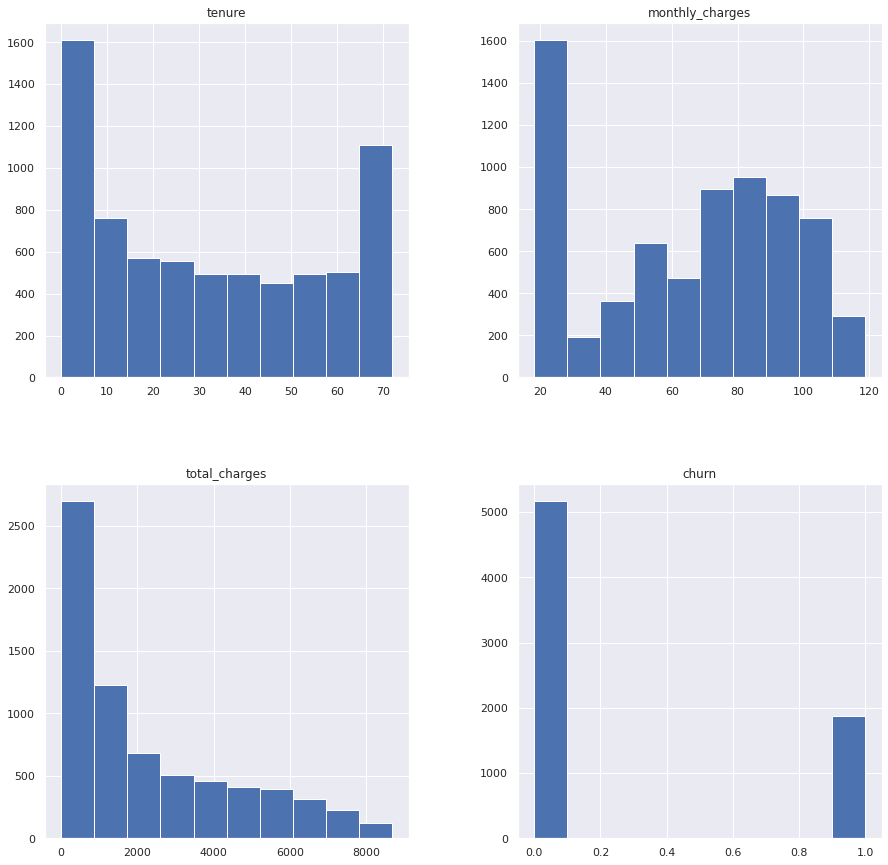

In [38]:
# Histograma
churn_df.hist(figsize = (15,15))
plt.show()

O Gráfico de Densidade, ou Density Plot, confirma a natureza bimodal e trimodal das variáveis **tenure** e **montly_charges**. Por sua vez, **total_charges**, a multiplicacao das duas variáveis anteiores, parece seguir uma distribuição lognormal.

Não iremos aplicar as transformações logarítmicas
Veremos que muitos dos atributos têm uma distribuição distorcida. Uma transformação como a Box-Cox, que pode aproximar a distribuição de uma Normal, pode ser útil neste caso.

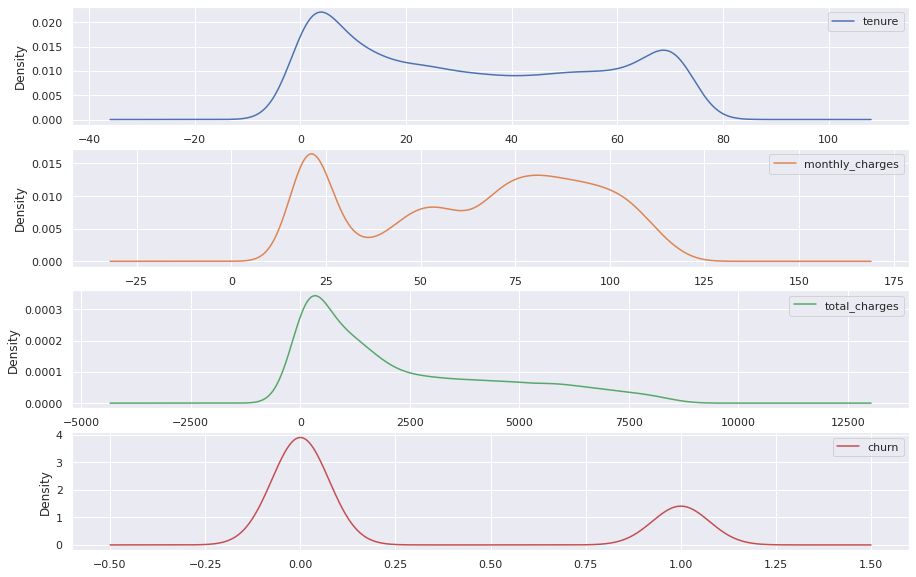

In [39]:
# Density Plot
churn_df.plot(kind = 'density', subplots = True, sharex = False, figsize = (15,10))
plt.show()

A análise dos boxplots não revelam informações novas. Confirma-se apenas que o conjunto de dados não possui outliers e que a variável **total_charges** posui uma cauda longa a sua direita.

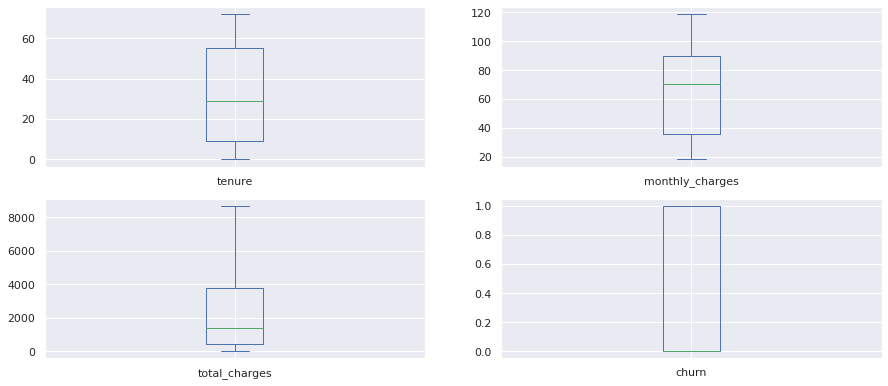

In [40]:
# Boxplot
churn_df.plot(kind = 'box', subplots = True, layout = (3,2), sharex = False, sharey = False, figsize = (15,10))
plt.show()

### 3.3. Visualizações Multimodais

Os algoritmos de correlação mais comumente utilizados (Pearson, Spearman e Kendall) não trabalham com variáveis categóricas.

Por se tratar de um conjunto de dados majoritariamente categórico, utilizaremos o coeficiente de correlação **Phi K** para analisar as variáveis.

O coeficiente de correlação Phi K consegue calcular as correlações entre variáveis categóricas e numéricas analisando o efeito que as variáveis categóricas possuem sobre as variáveis numéricas intervalares.

Diferente de outros algoritmos de para cálculo de correlação, ele consegue capturar de forma adequada relacionamentos não lineares entre variáveis, mas não consegue indicar a direção do relacionamento, apenas se ele existe e sua intensidade, pois os dados retornados variam entre um intervalo entre 0 e 1, sendo que 

* 0: não há correlação entre as variáveis.
* Próximo de 1 : há uma correlação negativa ou positiva entre as variáveis.


In [41]:
# Matriz de Correlação com Matplotlib Seaborn
interval_cols = ['tenure', 'monthly_charges', 'total_charges']

phik_overview_df = churn_df.phik_matrix(interval_cols=interval_cols)
phik_overview_df.sort_values(by="churn", inplace=True, axis=0)
phik_overview_df.sort_values(by="churn", inplace=True, axis=1)
sorted_phik_df = churn_df[ phik_overview_df.index ]
phik_overview_df = sorted_phik_df.phik_matrix(interval_cols=interval_cols)
display(phik_overview_df);



,phone_service,multiple_lines,streaming_tv,streaming_movies,device_protection,online_backup,internet_service,tech_support,online_security,partner,senior_citizen,contract,dependents,total_charges,paperless_billing,monthly_charges,payment_method,tenure,churn
phone_service,1.00,1.00,0.11,0.11,0.10,0.10,0.28,0.11,0.11,0.02,0.00,0.00,0.00,0.20,0.02,0.83,0.00,0.00,0.00
multiple_lines,1.00,1.00,0.59,0.59,0.56,0.56,0.74,0.54,0.54,0.09,0.09,0.24,0.01,0.49,0.10,0.71,0.17,0.37,0.02
streaming_tv,0.11,0.59,1.00,0.97,0.95,0.95,0.95,0.95,0.94,0.08,0.11,0.55,0.09,0.57,0.20,0.86,0.28,0.32,0.14
streaming_movies,0.11,0.59,0.97,1.00,0.95,0.95,0.95,0.95,0.94,0.08,0.11,0.55,0.08,0.57,0.20,0.86,0.29,0.33,0.14
device_protection,0.10,0.56,0.95,0.95,1.00,0.95,0.94,0.95,0.95,0.10,0.11,0.63,0.09,0.57,0.20,0.83,0.30,0.40,0.17
online_backup,0.10,0.56,0.95,0.95,0.95,1.00,0.94,0.95,0.95,0.09,0.11,0.58,0.10,0.57,0.20,0.82,0.29,0.40,0.18
internet_service,0.28,0.74,0.95,0.95,0.94,0.94,1.00,0.95,0.95,0.00,0.16,0.51,0.11,0.51,0.23,0.92,0.32,0.02,0.20
tech_support,0.11,0.54,0.95,0.95,0.95,0.95,0.95,1.00,0.95,0.08,0.14,0.67,0.11,0.54,0.20,0.82,0.32,0.36,0.21
online_security,0.11,0.54,0.94,0.94,0.95,0.95,0.95,0.95,1.00,0.09,0.13,0.64,0.12,0.53,0.21,0.81,0.32,0.37,0.21
partner,0.02,0.09,0.08,0.08,0.10,0.09,0.00,0.08,0.09,1.00,0.02,0.18,0.65,0.42,0.01,0.20,0.24,0.49,0.23




Por ser um algoritmo ainda novo, a interpretação da intensidade dos relacionamentos pode ser um tanto dificultada. Portanto, as linhas e colunas do dataframe contendo as correlações foram ordenados com base na intensidade do relacionamento com a variável target **churn**. Nesse sentido, as constatações anteriormente realizadas via análise das tabulações cruzadas com a variável target são reforçadas/confirmadas.

Ignorando a primeira coluna/linha (por tratar-se da própria variável target após a ordenação citada acima), podemos verificar que as variáveis que possuem a maior correlação com a mesma são:

- **tenure** indicando que os clientes mais novos possuem maior rotatividade e que, com o passar do tempo, tendem a se fidelizar, conforme análise anterior.

- **monthly_charges** indicando que os clientes que contratam os serviços mais caros (internet de fibra ótica) tendem a ter a maior rotatividade e que clientes que possuem apenas planos telefônicos, tendem a apresentar menor rotatividade (conforme análise anterior).

- **payment_method** indicando que os clientes que realizam pagamento via cheques eletrônicos(depósitos diretos) são os que apresentam a maior rotatividade(conforme análise anterior), possivelmente ligado a facilidade na qual os pagamentos podem ser sustados sem necessidade de contato com a operadora.

Existe uma alta correlação entre os diferentes serviços oferecidos e uma correlação dos mesmos com os valores mensais cobrados. Essa relação possivelmente pode ser explicada sobre o efeito que a contratação desses serviços possuem sobre o valor da mensalidade. Nesse sentido, é difícil interpretar as correlações reportadas por falta de uma intuição adequada sobre o seu significado, efeitos e características.

Mais detalhes sobre o coeficiente **Phi K** podem ser encontrados no link abaixo, inclusive o artigo no qual o mesmo foi apresentado.

https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

In [ ]:


plot_correlation_matrix(
    phik_overview_df.values
,   x_labels          = phik_overview_df.columns
,   y_labels          = phik_overview_df.index
,   vmin              = 0
,   vmax              = 1
,   color_map         = 'RdBu_r'
,   title             = r'Correlação $\phi_K$'
,   figsize=(25,25)
);
plt.tight_layout();


## 4. Pré-Processamento de dados



### 4.1. Tratamento das variáveis categóricas

Dado o elevado número de variáveis categóricas presentes no data set, iremos adotar a estratégia de **Dummy Encoding** para tranformar os dados categóricos em numéricos e posteriormente removendo as colunas redundantes.


In [ ]:
# transformando variáveis booleanas em numéricas (dummy encoding não é necessário)
for feature in BOOLEAN_FEATURES:
  churn_df[feature] = churn_df[feature].map(BOOLEAN_MAP)

# realizando o dummy encoding usando pandas
dummy_df = pd.get_dummies(
    data        = churn_df[CATEGORICAL_FEATURES]
,   prefix      = CATEGORICAL_FEATURES
,   prefix_sep  = "="
)

# concatenando as variáveis boleanas, categóricas codificadas, numéricas e variável target num novo dataset
churn_df = pd.concat([
    churn_df[ BOOLEAN_FEATURES ]
,   dummy_df
,   churn_df[ NUMERICAL_FEATURES ]
,   churn_df[ TARGET_VARIABLE ]
], axis=1)

# removendo variáveis equivalentes internet_service=No = 1
del churn_df["device_protection=No internet service"]
del churn_df["streaming_tv=No internet service"]
del churn_df["tech_support=No internet service"]
del churn_df["online_backup=No internet service"]
del churn_df["streaming_movies=No internet service"]
del churn_df["online_security=No internet service"]

# removendo variáveis equivalentes phone_service=0
del churn_df["multiple_lines=No phone service"]

# removendo variáveis codificada tornadas redundantes pelas deleções acima
del churn_df["multiple_lines=No"]
del churn_df["online_security=No"]
del churn_df["online_backup=No"]
del churn_df["device_protection=No"]
del churn_df["tech_support=No"]
del churn_df["streaming_tv=No"]
del churn_df["streaming_movies=No"]
del churn_df["internet_service=No"]


As colunas resultantes foram renomeadas para melhorar a legibilidade do dataframe.

In [ ]:
new_column_names = {
    'multiple_lines=Yes'                       : 'multiple_lines'
,   'internet_service=DSL'                     : 'dsl'
,   'internet_service=Fiber optic'             : 'fiber_optic'
,   'online_security=Yes'                      : 'online_security'
,   'online_backup=Yes'                        : 'online_backup'
,   'device_protection=Yes'                    : 'device_protection'
,   'tech_support=Yes'                         : 'tech_support'
,   'streaming_tv=Yes'                         : 'streaming_tv'
,   'streaming_movies=Yes'                     : 'streaming_movies'
,   'contract=Month-to-month'                  : 'monthly_contract'
,   'contract=One year'                        : 'one_year_contract'
,   'contract=Two year'                        : 'two_year_contract'
,   'payment_method=Bank transfer (automatic)' : 'bank_transfer'
,   'payment_method=Credit card (automatic)'   : 'credit_card'
,   'payment_method=Electronic check'          : 'electronic_check'
,   'payment_method=Mailed check'              : 'mailed_check'
}
churn_df.rename(columns=new_column_names, inplace=True)

## 4.2 Feature Engineering

Iremos tentar criar variáveis artificiais combinando as variáveis categóricas codificadas.

In [ ]:
# salvando o dataset para permitir reexecuções do códigos abaixo
orig_df = churn_df.copy()

In [ ]:
churn_df = orig_df.copy()
tenure_1st_quartile = 9 # o primeiro quartil da variável tenure conforme análise univariada anterior
charges_3rd_quartile = 89.85 # o terceiro quartil da variável tenure conforme análise univariada anterior
noise_std = 0.1
rows, cols = churn_df.shape
# client factor
# A análise das tabulações cruzadas revelou que a existência de parceiro e dependentes tendem a fidelizar o cliente.
# Em contrapartida, observou-se que clientes na terceira idade proporcionalmente tendem a cancelar os serviços
# de maneira mais frequente.
# A expectativa é de que quanto maior for o client_factor, maior a probabilidade de que ele venha a cancelar o seu contrato
noise_term = np.random.normal(loc=0.0, scale=noise_std, size=rows)
churn_df["client_factor"] = ((
    np.exp(churn_df["senior_citizen"]) # senior_citizen=1 aumenta a rotatividade
+   np.exp(np.abs(1-churn_df["partner"]))
+   np.exp(np.abs(1-churn_df["dependents"]))
+   np.exp((churn_df["tenure"] < tenure_1st_quartile).astype(float))
+   np.exp((churn_df["monthly_charges"] > charges_3rd_quartile).astype(float))
) / 3.0 + noise_term)

# internet factor
# A análise das tabulações cruzadas revelou que a existência a contratação dos
# serviços de supoerte técnico e de segurança online tendem a indicar que um usuário
# encontra-se fidelizado. A contratação da internet de fibra ótica, ao elevar o valor
# mensalmente cobrado, contribui com a rotatividade do cliente. Por outro lado,
# os clientes com internet DSL tendem a permanecer como cliente devido a valor 
# comparativamente mais baixo sendo cobrado.
# A expectativa é de que quanto maior for o internet_factor, maior a probabilidade de que ele venha a cancelar o seu contrato
noise_term = np.random.normal(loc=0.0, scale=noise_std, size=rows)
churn_df["internet_factor"] = ((
    np.exp(np.abs(1-churn_df["tech_support"])) 
+   np.exp(np.abs(1-churn_df["online_security"]))  
+   np.exp(churn_df["fiber_optic"]) # senior_citizen=1 aumenta a rotatividade
-   np.exp(churn_df["dsl"]) # dsl=1 diminui a rotatividade
+   np.exp((churn_df["tenure"] < tenure_1st_quartile).astype(float))
+   np.exp((churn_df["monthly_charges"] > charges_3rd_quartile).astype(float))
) / 3.0 + noise_term)

# financial factor
# A análise das tabulações cruzadas revelou que a existência o uso de cobrança digital,
# o uso de contratos mensais e o pagamento via cheque eletrônico são fatores que
# contribuem com a rotatividade dos clientes
# A expectativa é de que quanto maior for o financial_factor, maior a probabilidade de que ele venha a cancelar o seu contrato
noise_term = np.random.normal(loc=0.0, scale=noise_std, size=rows)
churn_df["financial_factor"] = ((
    np.exp(churn_df["monthly_contract"]) 
+   np.exp(churn_df["electronic_check"])
+   np.exp(churn_df["paperless_billing"])
+   np.exp((churn_df["tenure"] < tenure_1st_quartile).astype(float))
+   np.exp((churn_df["monthly_charges"] > charges_3rd_quartile).astype(float))
) / 3.0 + noise_term)

noise_term = np.random.normal(loc=0.0, scale=noise_std, size=rows)
churn_df["multi_factor"] = ((
    np.exp(churn_df["senior_citizen"]) # senior_citizen=1 piora as p
+   np.exp(np.abs(1-churn_df["partner"]))
+   np.exp(np.abs(1-churn_df["dependents"]))
+   np.exp(np.abs(1-churn_df["tech_support"])) 
+   np.exp(np.abs(1-churn_df["online_security"])) 
-   np.exp(churn_df["dsl"]) 
+   np.exp(churn_df["fiber_optic"])
+   np.exp(churn_df["monthly_contract"]) 
+   np.exp(churn_df["electronic_check"])
+   np.exp(churn_df["paperless_billing"])
+   np.exp((churn_df["tenure"] < tenure_1st_quartile).astype(float))
+   np.exp((churn_df["monthly_charges"] > charges_3rd_quartile).astype(float))
) / 9.0 + noise_term)

churn_df["churn"] = churn_df.pop("churn")
churn_df.describe()

In [ ]:
scatter_vars = [
  "client_factor", 
  "internet_factor", 
  "financial_factor", 
  "multi_factor", 
  "tenure",
  "monthly_charges",
  "total_charges"
]

sns.pairplot(
    churn_df
,   diag_kind = "hist"    
,   vars      = scatter_vars
,   hue       = "churn"
)


### 4.3. Separação em conjunto de treino e conjunto de teste

Para evitar que os processo de treino do modelo resulte em um modelo sobreajustado aos dados (overfitting) é importante testar o modelo com dados ainda não vistos. Modelos sobreajustados tendem a ter uma performance pior estes dados, sendo isso um forte indicativo de que o modelo não foi capaz de generalizar seu poder preditivo.

É uma boa prática usar um conjunto de teste, uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final.

Trata-se de um boa prática usada para avaliação sistemática da performance do modelo.

Usaremos 80% do conjunto de dados para modelagem e treino, e guardaremos 20% para teste, usando a estratégia train-test-split.

## 4.3 Normalização

Dado as significativas diferenças entre as escalas das variáveis, a ausência de outliers presentes no conjunto de dados e a presença de variáveis numéricas geradas a partir de dados categóricos usando dummy encoding(representadas como 0's ou 1's), o conjunto de dados será tratado usando o procedimento conhecido como normalização. A normalização irá sempre mapear o intervalo de valores observados nas variávéis para o intervalo entre 0 e 1.

A normalização feita abaixo precisará ser posteriormente refeita no pipeline, pois a separação do conjunto de dados de treino e teste ainda não foi realizada, o que poderia ser caracterizado como um data leakage da variável target.

In [ ]:
# cômputo da importância das variáveis utilizando RandomForest
all_but_target = churn_df.columns.difference([TARGET_VARIABLE])
X_df = churn_df[all_but_target]
y = churn_df[TARGET_VARIABLE]

classifier = RandomForestClassifier(
    n_estimators  = 150
,   bootstrap     = True   
,   class_weight  = "balanced_subsample"
)
classifier.fit(X_df, y)
importances = classifier.feature_importances_
std = np.std([ classifier.feature_importances_ for tree in classifier.estimators_], axis=0)
importances_df = pd.DataFrame({
    "variáveis"       : X_df.columns
,   "importâncias"    : importances
,   "desv.pad"        : std
})

f, ax = plt.subplots(figsize=(6, 15))
importances_df.sort_values("importâncias", ascending=False, inplace=True)
sns.barplot(
    x     = "importâncias"
,   y     = "variáveis"
,   data  =  importances_df
#,   label =  "Decréscimo médio de impureza"
)

#fig, ax = plt.subplot()
#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

In [ ]:
# removendo variáveis menos importantes
keep_n_columns    = 16
kept_columns      = importances_df["variáveis"][0:keep_n_columns].to_list()
not_kept_columns  = X_df.columns.difference(kept_columns)
X_df              = X_df[ kept_columns ] 
X_df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df.values
,   y
,   test_size     = TEST_PCT_SIZE
,   shuffle       = True
,   random_state  = RANDOM_STATE
,   stratify      = y # com estratificação
)

X_train_df = pd.DataFrame(X_train, columns=X_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_df.columns)
y_train_df = pd.DataFrame(y_train, columns=[TARGET_VARIABLE])
y_test_df = pd.DataFrame(y_test, columns=[TARGET_VARIABLE])

## 5. Modelos de Classificação

### 5.1. Criação e avaliação de modelos: linha base

Não sabemos de antemão quais modelos performarão bem neste conjunto de dados. Assim, usaremos a validação cruzada 10-fold (já detalhada anteriormente) e avaliaremos os modelos usando a métrica de acurácia. Vamos inicialmente configurar os parâmetros de número de folds e métrica de avaliação.

In [ ]:
# Parâmetros e partições da validação cruzada estratificada
kfold = StratifiedKFold(
    n_splits      = K_FOLDS
,   shuffle       = True
,   random_state  = RANDOM_STATE
) 
# configura pandas para exibição de apenas duas casas decimais nas variaveis
pd.set_option('display.float_format', lambda x: '%0.3f' % x)


In [ ]:
# Configuração do pipeline

# Os transformadores numéricos são utilizado spara processamento de todas as variáveis não categóricas.
numeric_transformer = Pipeline([
  ("scaler", StandardScaler())    
])

column_transformer = ColumnTransformer(
  transformers = [
    ("num", numeric_transformer, NUMERICAL_FEATURES_AFTER_FEAT_ENG)
  ],
  # importante usar passthrough quando nem todos os atributos forem processados
  remainder="passthrough" 
)

# Este pipelie será ajustado diversas vezes durante o processo de otimização dos hiper parâmetros.
pipeline = Pipeline([
    # a primeira fase consiste no pré-processamento das variáveis numéricas
    ("feature_scaling", column_transformer),
    # redução de dimesionalidade
    ("reduce_dim", PCA()),
    # O algoritmo de regressão e seus parâmetros serão configurados via gridsearch
    ("classifier", SVC())
])

stk_pipeline = Pipeline([
    # O algoritmo de regressão e seus parâmetros serão configurados via gridsearch
    ("classifier", SVC())                         
])

In [ ]:
def search_hyperparameters(param_grid, num_iter, algo):
  model_settings = MODEL_SETTINGS[algo]
  if model_settings["train"]:
    grid = RandomizedSearchCV(
        estimator           = pipeline
    ,   param_distributions = param_grid
    ,   scoring             = SCORING_METRIC
    ,   cv                  = kfold
    ,   n_iter              = num_iter
    ,   return_train_score  = RETURN_TRAIN_SCORE
    )
    grid.fit(X_train_df, y_train_df)
    save_model(grid, model_settings["model_file"])
  else:
    grid = read_model(model_settings["model_file"])
  print(f"Melhor recall: {grid.best_score_}")
  print("Melhor estimador -> ")
  pprint(grid.best_params_)
  results_df = pd.DataFrame(grid.cv_results_)
  results_df.to_excel(OUTPUT_TRAINING_FILE_TMPLT.replace("{algo}", algo))
  return grid, results_df

def plot_mean_std(results_df, param_name, new_name):
  results_df[new_name] = results_df[param_name]
  return sns.scatterplot(
      data=results_df
  ,   x="mean_test_score"
  ,   y="std_test_score"
  ,   hue=new_name
  )
  
def show_top_n(results_df, n, column_mapping):
  results_df.sort_values("mean_test_score", inplace=True, ascending=False)
  columns = {new_name: results_df[col_name] for new_name, col_name in column_mapping.items()}
  params_df = pd.DataFrame(columns)
  display(params_df.head(n))
  return params_df

def report_results(grid, algo):
  y_test_hat              = grid.best_estimator_.predict(X_test_df)
  y_test_prob             = grid.best_estimator_.predict_proba(X_test_df)[:,1]
  
  acc_test_score          = accuracy_score(y_test, y_test_hat)  
  prec_test_score         = precision_score(y_test, y_test_hat)  
  rec_test_score          = recall_score(y_test, y_test_hat)  
  f1_test_score           = f1_score(y_test, y_test_hat)
  rocauc_test_auc         = roc_auc_score(y_test, y_test_prob)
  
  print(f"== Test accuracy score  :  {acc_test_score} ===")
  print(f"== Test precision score :  {prec_test_score} ===")
  print(f"== Test recall score    :  {rec_test_score} ===")
  print(f"== Test F1 Score        :  {f1_test_score} ===")
  print(f"== Test ROC AUC         :  {rocauc_test_auc} ===")
  
  algo_name = MODEL_SETTINGS[algo]['name']
  RESULT_COLUMNS = []
  RESULTS[algo] = {
      "algoritmo"     : algo_name
  ,   "acurácia"      : acc_test_score
  ,   "precisão"      : prec_test_score
  ,   "recall"        : rec_test_score
  ,   "F1"            : f1_test_score
  ,   "ROC AUC"       : rocauc_test_auc
  }
  
  plot_confusion_matrix(grid.best_estimator_, X_test_df, y_test_df)
  plt.show()
  plot_precision_recall_curve(grid.best_estimator_, X_test_df, y_test_df)
  plt.show()
  plot_roc_curve(grid.best_estimator_, X_test_df, y_test_df)
  plt.show()
  print(classification_report(y_test, y_test_hat))

def save_model(grid, file_name):
  import pickle
  data = {
    "best_score_"     : grid.best_score_
  , "best_params_"    : grid.best_params_
  , "best_estimator_" : grid.best_estimator_
  , "cv_results_"     : grid.cv_results_
  , "grid"            : grid
  }  
  with open(file_name, "wb") as fh:
    pickle.dump(data, fh)

def read_model(file_name):
  import pickle
  with open(file_name, "rb") as fh:
    data                  = pickle.load(fh)
  grid                  = data["grid"]
  grid.best_score_      = data["best_score_"]
  grid.best_params_     = data["best_params_"]
  grid.best_estimator_  = data["best_estimator_"]
  grid.cv_results_      = data["cv_results_"]
  return grid

In [ ]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # Logistic Regression
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [LogisticRegression()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__penalty"           : ["elasticnet"],
    "classifier__class_weight"      : ["balanced"],
    "classifier__solver"            : ["saga"],
    "classifier__l1_ratio"          : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  },
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [LogisticRegression()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__penalty"           : ["none"],
    "classifier__class_weight"      : ["balanced"],
  }  
]
if QUICK_RUN:
  logreg_grid, logreg_results_df =  search_hyperparameters(param_grid, 20, "logreg")
else:
  logreg_grid, logreg_results_df =  search_hyperparameters(param_grid, 200, "logreg")

In [ ]:
plot_mean_std(logreg_results_df, "param_classifier__penalty", "penalty")

Os melhores resultados obtidos com a regressão logística obtiveram um score F1 perto de 0.632 com um desvio padrão da métrica calculado aproximadamente 0.02.

In [ ]:
column_mapping={
    "mean_score"      : "mean_test_score"
,   "std_score"       : "std_test_score"
,   "l1_ratio"        : "param_classifier__l1_ratio"
,   "penalty"         : "param_classifier__penalty"
,   "feature_scaling" : "param_feature_scaling__num__scaler"
,   "reduce_dim"      : "param_reduce_dim"
}
logreg_params_df = show_top_n(logreg_results_df, 50, column_mapping)

Os melhores resultados obtidos não usaram nenhum tipo de normalização ou padronização dos dados e o uso de redução de dimensionalidade para 5 features via PCA parece ter um efeito positivo na maioria dos casos

In [ ]:
report_results(logreg_grid, "logreg")

<<Conclusão>>

In [ ]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # KNeighborsClassifier
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [KNeighborsClassifier()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__algorithm"         : ["kd_tree"],
    "classifier__metric"            : ["minkowski"],
    "classifier__p"                 : [0.5, 1.0, 1.5, 2.0], # manhattan, euclidean
    "classifier__n_neighbors"       : [5, 7, 10, 13, 15, 17, 20],
    "classifier__weights"           : ["uniform", "distance"]
  }  
]
if QUICK_RUN:
  knn_grid, knn_results_df =  search_hyperparameters(param_grid, 20, "knn")
else:
  knn_grid, knn_results_df =  search_hyperparameters(param_grid, 200, "knn")

In [ ]:
plot_mean_std(knn_results_df, "param_classifier__n_neighbors", "n_neighbors")

Os melhores resultados obtidos com o algoritmo KNN obtiveram um score F1 inferior a 0.6 com um desvio padrão da métrica calculado em aproximadamente 0.03.

In [ ]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "n_neighbors"     : "param_classifier__n_neighbors"
, "minkowski-p"     : "param_classifier__p"
, "weights"         : "param_classifier__weights"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
}
knn_params_df = show_top_n(knn_results_df, 50, column_mapping)

Os melhores resultados obtidos utilizaram-se de 13 ou mair vizinhos e a redução de dimensionalidade PCA não foi utilizada. Os melhores resultados tipicamente utilizaram o parâmetro p da métrica de Minkowski menor do que 2 na maioria dos casos (indicando que a distância euclidiana não é adequada para uso nesse conjunto de dados).

In [ ]:
report_results(knn_grid, "knn")

O cômputo do score F1 usando o conjunto de treinamento indica claramente que ocorreu overfitting na parametrização usada para o algoritmo KNN.

In [ ]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # GaussianNB
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [GaussianNB()],
    "classifier__var_smoothing"     : [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
  }  
]
if QUICK_RUN:
  nb_grid, nb_results_df =  search_hyperparameters(param_grid, 20, "nb")
else:  
  nb_grid, nb_results_df =  search_hyperparameters(param_grid, 200, "nb")

In [ ]:
plot_mean_std(nb_results_df, "param_classifier__var_smoothing", "var_smoothing")

Os melhores resultados obtidos com o algoritmo KNN obtiveram um score F1 superior a 0.62 com um desvio padrão da métrica calculado em aproximadamente 0.018

In [ ]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "var_smoothing"   : "param_classifier__var_smoothing"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
}
pd.set_option('display.float_format', lambda x: '%0.10f' % x)
nb_params_df = show_top_n(nb_results_df, 50, column_mapping)
pd.set_option('display.float_format', lambda x: '%0.3f' % x)

O algoritmo de NaiveBayes não possui muitos hiperparâmetros e comporta-se basicamente de maneira indiferente quanto a aplicação ou não do procedimento de normalização ou padronização.

A redução de dimensionalidade, via PCA não ajuda em nada no algoritmo.

O conjunto de dados, quando inicialmente analisado, parecia ser um bom candidato para aplicação deste algoritmo devido a elevada presença de variáveis categóricas, entretanto, a performance observada do mesmo foi inferior à performance da regressão logística, até o momento o melhor algoritmo observado.

In [ ]:
report_results(nb_grid, "nb")

In [ ]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # DecisionTreeClassifier
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [DecisionTreeClassifier()],
    "classifier__class_weight"      : [None, "balanced"],
    "classifier__criterion"         : ["gini", "entropy"],
    "classifier__splitter"          : ["best", "random"],
    "classifier__max_features"      : [None, "auto", "sqrt", "log2"],
  }  
]
if QUICK_RUN:
  dt_grid, dt_results_df =  search_hyperparameters(param_grid, 20, "dt")
else:
  dt_grid, dt_results_df =  search_hyperparameters(param_grid, 200, "dt")

In [ ]:
plot_mean_std(dt_results_df, "param_classifier__criterion", "criterion")

Os melhores resultados obtidos com o algoritmo de Árvore de Decisões obtiveram um score F1 com cerca de 0.50 com um desvio padrão da métrica calculado em aproximadamente 0.003

Surpreendentemente, o algoritmo se comporta pior do que a regressão logística.

In [ ]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "class_weight"    : "param_classifier__class_weight"
, "criterion"       : "param_classifier__criterion"
, "splitter"        : "param_classifier__splitter"
, "max_features"    : "param_classifier__max_features"
}
dt_params_df = show_top_n(dt_results_df, 50, column_mapping)

O algoritmo de Árvore de Decisão comportou-se melhor com o critério *gini* e parece ter se beneficiado do procedimento de redução de dimensionalidade usando PCA. O balanceamento de classes parece ter ajudado também no processo de treino.

In [ ]:
report_results(dt_grid, "dt")

Assim como para o algoritmo KNN, O cômputo do score F1 usando o conjunto de treinamento indica claramente que ocorreu overfitting na parametrização usada para o algoritmo de Árvore de Decisões.

In [ ]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # SVC
  {
    "feature_scaling__num__scaler"  : [MinMaxScaler(), StandardScaler()], # SVC precisa ter os argumentos escalonados para uma melhor performance
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [SVC(probability=True)],
    "classifier__kernel"            : ["linear","rbf"],
    "classifier__gamma"             : ["scale", "auto"],
    "classifier__class_weight"      : ["balanced"],
    #"classifier__C"                 : [0.0, 0.5, 1.0, 1.5, 2.0],
  }  
]
if QUICK_RUN:
  svm_grid, svm_results_df =  search_hyperparameters(param_grid, 5, "svm")
else:  
  svm_grid, svm_results_df =  search_hyperparameters(param_grid, 50, "svm")

In [ ]:
plot_mean_std(svm_results_df, "param_classifier__kernel", "kernel")

Surpreendentemente, o SVM com kernel linear se comportou melhor do que o kernel de *radial basis function*, usado por padrão.

Os melhores scores F1 obtidos

In [ ]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "gamma"           : "param_classifier__gamma"
, "kernel"          : "param_classifier__kernel"
}
svm_params_df = show_top_n(svm_results_df, 50, column_mapping)

In [ ]:
report_results(svm_grid, "svm")

In [ ]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # AdaBoostClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                      : [AdaBoostClassifier()],
    "classifier__n_estimators"        : [25, 50, 75, 100],
    "classifier__learning_rate"       : [0.001, 0.01, 0.1, 1.0]
  }  
]
if QUICK_RUN:
  ada_grid, ada_results_df =  search_hyperparameters(param_grid, 5, "ada")
else:  
  ada_grid, ada_results_df =  search_hyperparameters(param_grid, 64, "ada")

In [ ]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "n_estimators"    : "param_classifier__n_estimators"
, "learning_rate"   : "param_classifier__learning_rate"
}
ada_params_df = show_top_n(ada_results_df, 50, column_mapping)

In [ ]:
report_results(ada_grid, "ada")

In [ ]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # GradientBoostingClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                      : [GradientBoostingClassifier()],
    "classifier__loss"                : ["log_loss", "deviance", "exponential"],
    "classifier__n_estimators"        : [50, 75, 100, 150],
    "classifier__learning_rate"       : [0.1, 0.3, 0.5, 0.7, 1.0],
    "classifier__max_depth"           : [3, 5, 10],
    "classifier__max_features"        : [None, "sqrt", "log2"]
  }  
]
if QUICK_RUN:
  gb_grid, gb_results_df =  search_hyperparameters(param_grid, 10, "gb")
else:  
  gb_grid, gb_results_df =  search_hyperparameters(param_grid, 100, "gb")

In [ ]:
plot_mean_std(gb_results_df, "param_classifier__n_estimators", "n_estimators")

In [ ]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "loss"            : "param_classifier__loss"
, "n_estimators"    : "param_classifier__n_estimators"
, "loss"            : "param_classifier__loss"
, "learning_rate"   : "param_classifier__learning_rate"
, "max_depth"       : "param_classifier__max_depth"
, "max_features"    : "param_classifier__max_features"
}
gb_params_df = show_top_n(gb_results_df, 50, column_mapping)

In [ ]:
report_results(gb_grid, "gb")

In [ ]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # RandomForestClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough"], #PCA(n_components=5), PCA(n_components=10)],
    "classifier"                      : [RandomForestClassifier()],
    "classifier__n_estimators"        : [50, 100, 150],
    "classifier__criterion"           : ["gini", "entropy"],
    "classifier__bootstrap"           : [True, False],
    "classifier__n_jobs"              : [-1],
    "classifier__class_weight"        : ["balanced", "balanced_subsample"],
  }
]
if QUICK_RUN:
  rf_grid, rf_results_df =  search_hyperparameters(param_grid, 10, "rf")
else:
  rf_grid, rf_results_df =  search_hyperparameters(param_grid, 100, "rf")

In [ ]:
plot_mean_std(rf_results_df, "param_classifier__n_estimators", "n_estimators")

In [ ]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "n_estimators"    : "param_classifier__n_estimators"
, "criterion"       : "param_classifier__criterion"
, "bootstrap"       : "param_classifier__bootstrap"
, "class_weight"    : "param_classifier__class_weight"
}
rf_params_df = show_top_n(rf_results_df, 50, column_mapping)

In [ ]:
report_results(rf_grid, "rf")

In [ ]:
from itertools import combinations

model_settings = MODEL_SETTINGS["vt"]

def compute_score(estimator):
  y_train_prob        = estimator.predict_proba(X_train_df)[:,1]
  train_score         = recall_score(y_train, y_train_prob)
  return recall_score

if not model_settings["train"]:
    with open(model_settings["model_file"], "rb") as fh:
      classifier = pickle.load(fh)
else:
  # Realiza a busca por hiperparâmetros
  estimators_weights = [
      ( logreg_grid.best_estimator_,  logreg_grid.best_score_ )
  ,   ( knn_grid.best_estimator_,     knn_grid.best_score_    )
  ,   ( nb_grid.best_estimator_,      nb_grid.best_score_     )
  ,   ( svm_grid.best_estimator_,     svm_grid.best_score_    )
  ,   ( ada_grid.best_estimator_,     ada_grid.best_score_    )
  ,   ( gb_grid.best_estimator_,      gb_grid.best_score_     )
  ,   ( rf_grid.best_estimator_,      rf_grid.best_score_     )
  ]

  best_score      = -99999
  best_estimators = None
  best_type       = None

  for voting_type in ["soft", "hard"]:
    for i in [3, 5, 7]:
      for comb_estimators_weights in combinations(estimators_weights, i):
        # https://stackoverflow.com/questions/13635032/what-is-the-inverse-function-of-zip-in-python
        comb_estimators, weights = zip(*comb_estimators_weights)
        classifier = EnsembleVoteClassifier(clfs=comb_estimators, weights=weights, voting=voting_type, refit=False)  
        classifier.fit(None, y_train_df)
        score = compute_score(classifier)
        if score > best_score:
          best_score      = score
          best_estimators = comb_estimators_weights
          best_type       = voting_type

  comb_estimators, weights = zip(*best_estimators)
  classifier = EnsembleVoteClassifier(clfs=comb_estimators, weights=weights, voting=best_type, refit=False)    
  classifier.fit(None, y_train_df)
  with open(model_settings["model_file"], "wb") as fh:
    pickle.dump(classifier, fh)
  
print(f"best combination of estimators: {classifier.clfs}")
print(f"estimators weights: {classifier.weights}")
print(f"voting type: {classifier.voting}")

class PseudoGrid:
  def __init__(self, estimator):
      self.best_estimator_ = estimator
grid = PseudoGrid(classifier)
report_results(grid, "vt")

In [ ]:
records = list(RESULTS.values())
global_results_df = pd.DataFrame.from_records(records, columns=RESULT_COLUMNS, index="algoritmo")
global_results_df.sort_values("ROC AUC", ascending=False, inplace=True)
pd.set_option('display.float_format', lambda x: '%0.5f' % x)
display(global_results_df)
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

<<CONCLUSÃO>>

Vamos adicionar também os algoritmos de ensemble que estudamos:

## 7. Finalização do Modelo

Analisando os resultados até aqui, verificamos que o modelo que mostrou melhor acurácia média para o problema foi o que usou Extra Trees como algoritmo (apesar de ter um  desvio padrão relativamente alto). Relembrando o Experimento 1 (uma vez que o Experimento 2 não trouxe resultados melhores), nossos resultados foram:

*Para o dataset **Sem tratamento de missings**, os melhores modelos em termos de acurácia foram: ET-orig (0,779), Bag-orig (0,77), LR-padr	(0,77), GB-orig	(0,769) e Bag-padr (0,767). Já para o dataset **Com tratamento de missings**, os melhores modelos foram: Vot-orig (0,774), ET-norm (0,77), SVM-norm (0,766), LR-padr (0,764) e RF-norm (0,764).*

Examinando também o desvio padrão, poderíamos, por exemplo, optar por utilizar o modelo construído com o algoritmo de Regressão Logística, com os dados sem tratamento de missings, visão padronizada. Considerando o dataset "Sem tratamento de missings", este modelo ficou na 2a posição em termos de acurácia média, mas com um desvio padrão menor do que o que alcançou a 1a posição. Além disso, explicar como funciona este modelo para os usuários não técnicos tende a ser mais simples.

A seguir, finalizaremos este modelo, treinando-o em todo o conjunto de dados de treinamento (sem validação cruzada) e faremos predições para o conjunto de dados de teste que foi separado logo no início do exemplo, a fim de confirmarmos nossas descobertas.

Primeiro, iremos realizar a padronização dos dados de entrada. Depois, treinaremos o modelo e exibiremos a acurácia de teste, a matriz de confusão e o relatório de classificação.

In [ ]:
# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200) # substitua aqui se quiser usar outro modelo
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Por meio do conjunto de teste, verificamos que alcançamos uma acurácia de 77,22% em dados não vistos. Este resultado foi ainda melhor do que a nossa avaliação anterior da regressão logíistica. Valores semelhantes são esperados quando este modelo estiver executando em produção e fazendo predições para novos dados.

Vamos agora preparar o modelo para utilização. Para isso, vamos treiná-lo com todo o dataset, e não apenas o conjunto de treino.

In [ ]:
# Preparação do modelo com TODO o dataset (e não apenas a base de treino)
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

## 8. Aplicando o modelo em dados não vistos

Agora imagine que chegaram 3 novas instâncias, mas não sabemos a classe de saída. Podemos então aplicar nosso modelo recém-treinado para estimar as classes! Para tal, será necessário antes padronizar os dados (usando a mesma escala dos dados usados treinamento do modelo!).

In [ ]:
# Novos dados - não sabemos a classe!
data = {'preg':  [1, 9, 5],
        'plas': [90, 100, 110],
        'pres': [50, 60, 50],
        'skin': [30, 30, 30],
        'test': [100, 100, 100],
        'mass': [20.0, 30.0, 40.0],
        'pedi': [1.0, 2.0, 1.0],
        'age': [15, 40, 40],  
        }

atributos = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)
print(X_entrada)

In [ ]:
# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

In [ ]:
# Estimativa de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

## Resumo

Resumidamente, neste exemplo trabalhamos com um problema de classificação binária de ponta a ponta. As etapas abordadas foram:
* Definição do problema (Pima Indians Diabetes).
* Carga dos dados
* Análise  e tratamento dos dados (verificamos que estavam na mesma escala, mas com diferentes distribuições de dados e possíves missings).
* Avaliação de modelos de linha base, considerando o dataset original e com tratamento de missings.
* Avaliação de modelos com normalização e padronização dos dados.
* Ajuste dos modelos, buscando melhorar o KNN e o SVM.
* Finalização do modelo (use todos os dados de treinamento e valide usando o conjunto de dados de teste).

É importante ressaltar que este exemplo não buscou ser exaustivo, apresentando apenas uma parte dos muitos recursos disponíveis na biblioteca Scikit-Learn. Poderíamos ter testado outras operações de pré-processamento de dados (como feature selection), outros valores de hiperparâmetros e ainda, outros modelos de classificação. Recomendamos que você explore a documentação disponível e incremente este notebook com novas possibilidades.

## Para saber mais:
* Statistical Significance Tests for Comparing Machine Learning Algorithms: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
* Hypothesis Test for Comparing Machine Learning Algorithms: https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/
* How to Calculate Parametric Statistical Hypothesis Tests in Python: https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/
* How to Use Statistical Significance Tests to Interpret Machine Learning Results: https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/
* 17 Statistical Hypothesis Tests in Python (Cheat Sheet): https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
